In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!tar -xvf /content/drive/MyDrive/gsoc/data.tgz

Streaming output truncated to the last 5000 lines.
data/image_140466812021761890849935117392024097947.npy
data/image_214454232775476126858435938728675756697.npy
data/image_130801378814327756070396393793485679451.npy
data/image_311893850764781353709529115536192378408.npy
data/image_282165301331939040711285061265397272591.npy
data/image_21440908318479958144560759949570839926.npy
data/image_14246263583378039485404972992679267669.npy
data/image_14159338952001522610968069444327016917.npy
data/image_136653021479910190046378102527256138307.npy
data/image_332932571917593010534093958031892783820.npy
data/image_270111698154078866315002421949443996447.npy
data/image_141276881797963724247841965871917381705.npy
data/image_189348898416623356872431659680862005654.npy
data/image_2066840381301645643610836490276655881.npy
data/image_309460885844656250230861071645143094921.npy
data/image_258134283852911782251417926629741928725.npy
data/image_178762768427299605340851784625807099718.npy
data/image_30301588

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
path = '/content/data/'

TRAINING_DATA=[]
TARGET=[]

for f in tqdm(os.listdir(path)):
    file_path = path + f
    (img, target) = np.load(file_path,allow_pickle=True)
    TRAINING_DATA.append(img)
    TARGET.append(target)
        
TRAINING_DATA = np.array(TRAINING_DATA)
TARGET = np.array(TARGET).reshape(-1,1)

100%|██████████| 25000/25000 [00:35<00:00, 700.63it/s]


Splitting the data into Train, Validation and Test Sets.

- **TRAIN_PCT** = 90% * 80% = **72%**
- **VALID_PCT** = 90% * 80% = **18%**
- **TEST_PCT** = **10%**

In [6]:
np.random.seed(SEED)

TEST_PCT = 0.1
VALID_PCT = 0.2
N_EXAMPLES = len(TRAINING_DATA)
idx=np.arange(N_EXAMPLES)
np.random.shuffle(idx)

TEST_SIZE = int(TEST_PCT*N_EXAMPLES)
VALID_SIZE = int((1-TEST_PCT)*VALID_PCT*N_EXAMPLES)

test_idx = idx[:TEST_SIZE]
val_idx = idx[TEST_SIZE:TEST_SIZE+VALID_SIZE]
train_idx = idx[TEST_SIZE+VALID_SIZE:]

train_data = TRAINING_DATA[train_idx]
val_data = TRAINING_DATA[val_idx]
test_data = TRAINING_DATA[test_idx]

train_target = TARGET[train_idx]
val_target = TARGET[val_idx]
test_target = TARGET[test_idx]

train_data.shape, val_data.shape, test_data.shape, train_target.shape, val_target.shape, test_target.shape

((18000, 150, 150),
 (4500, 150, 150),
 (2500, 150, 150),
 (18000, 1),
 (4500, 1),
 (2500, 1))

In [7]:
def plot_images(images):
    
    fig = plt.figure(figsize=(5,5))
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i], cmap = 'bone')
        ax.axis('off')

In [8]:
train_data = list(zip(train_data,train_target))
val_data = list(zip(val_data,val_target))
test_data = list(zip(test_data,test_target))

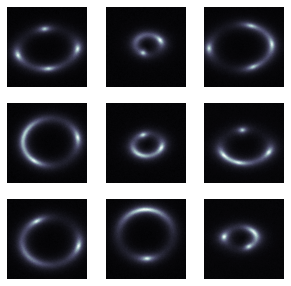

In [9]:
N_IMAGES = 9

images = [image for image, target in [train_data[i] for i in range(N_IMAGES)]] 

plot_images(images)

In [10]:
BATCH_SIZE = 50

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(val_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                 batch_size = BATCH_SIZE)

In [11]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)
        
    def forward(self, x):
        
        #x = [batch size, height, width]
        
        batch_size = x.shape[0]

        x = x.view(batch_size, -1).float()
        
        #x = [batch size, height * width]
        
        h_1 = F.relu(self.input_fc(x))
        
        #h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))

        #h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        
        #y_pred = [batch size, output dim]
        
        return y_pred, h_2

In [12]:
INPUT_DIM = 150 * 150 
OUTPUT_DIM = 1

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,650,451 trainable parameters


In [15]:
optimizer = optim.Adam(model.parameters())

In [16]:
criterion = nn.MSELoss()

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
model = model.to(device)
criterion = criterion.to(device)

In [19]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.float().to(device)
        y = y.float().to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [20]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.float().to(device)
            y = y.float().to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
EPOCHS = 50

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss = train(model, train_iterator, optimizer, criterion, device)
    valid_loss = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_task3.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 18633.533
	 Val. Loss: 88.913
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 126.982
	 Val. Loss: 53.254
Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 77.403
	 Val. Loss: 47.237
Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 83.500
	 Val. Loss: 42.463
Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 98.674
	 Val. Loss: 28.511
Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 72.736
	 Val. Loss: 99.147
Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 53.436
	 Val. Loss: 27.635
Epoch: 08 | Epoch Time: 0m 4s
	Train Loss: 64.821
	 Val. Loss: 23.130
Epoch: 09 | Epoch Time: 0m 4s
	Train Loss: 59.425
	 Val. Loss: 14.439
Epoch: 10 | Epoch Time: 0m 4s
	Train Loss: 39.413
	 Val. Loss: 533.364
Epoch: 11 | Epoch Time: 0m 4s
	Train Loss: 27.684
	 Val. Loss: 9.038
Epoch: 12 | Epoch Time: 0m 4s
	Train Loss: 22.988
	 Val. Loss: 21.563
Epoch: 13 | Epoch Time: 0m 4s
	Train Loss: 51.140
	 Val. Loss: 39.094
Epoch: 14 | Epoch Time: 0m 4s
	Train Loss: 27.994
	 Val. Loss: 9.045
Epoch: 15 | Epoch

In [23]:
model.load_state_dict(torch.load('model_task3.pt'))

test_loss = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f}')

Test Loss: 2.449


In [24]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    preds = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.float().to(device)

            y_pred, _ = model(x)

            images.append(x.cpu())
            preds.append(y_pred.cpu())

    images = torch.cat(images, dim = 0)
    preds = torch.cat(preds, dim = 0)

    return images.numpy(), preds.numpy()

In [25]:
from sklearn.metrics import r2_score, mean_squared_error

_, test_preds = get_predictions(model, test_iterator, device)

r2_score = r2_score(test_target,test_preds)
test_loss = mean_squared_error(test_target,test_preds)

print(f'Val MSE: {best_valid_loss:.3f} | Test MSE: {test_loss:.3f} | Test R2: {r2_score:.4f}')

Val MSE: 2.469 | Test MSE: 2.449 | Test R2: 0.9998
